## Text2Mesh Colab Notebook
Colab notebook for [Text2Mesh](https://github.com/threedle/text2mesh). Notebook made by [mfrashad](https://github.com/mfrashad).

In [16]:
#@title Setup
!pip install trimesh==3.9.33 einops==0.3.2 scipy==1.5.2 siren-pytorch==0.1.5 usd-core==21.8 torch==1.9.0 torchtext==0.10.0 torchvision==0.10.0 cython==0.29.20 "git+https://github.com/openai/CLIP.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-816ykn9w
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-816ykn9w


In [13]:
#@title Install dependency (Kaolin)
!git clone --recursive https://github.com/NVIDIAGameWorks/kaolin
%cd kaolin
!git checkout v0.10.0
!python setup.py develop
%cd ..

Cloning into 'kaolin'...
remote: Enumerating objects: 4012, done.
remote: Counting objects: 100% (595/595), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 4012 (delta 314), reused 520 (delta 261), pack-reused 3417
Receiving objects: 100% (4012/4012), 85.67 MiB | 36.67 MiB/s, done.
Resolving deltas: 100% (2096/2096), done.
Submodule 'third_party/cub' (https://github.com/NVIDIA/cub) registered for path 'third_party/cub'
Cloning into '/content/text2mesh/kaolin/third_party/cub'...
remote: Enumerating objects: 31921, done.        
remote: Counting objects: 100% (199/199), done.        
remote: Compressing objects: 100% (116/116), done.        
remote: Total 31921 (delta 105), reused 157 (delta 80), pack-reused 31722        
Receiving objects: 100% (31921/31921), 17.08 MiB | 30.58 MiB/s, done.
Resolving deltas: 100% (27005/27005), done.
Submodule path 'third_party/cub': checked out '499a7bad3416fcc71a7c50351d6b3cdbf3fbbc27'
/content/text2mesh/kaolin
Note: checking out

In [4]:
#@title Get text2mesh
!git clone https://github.com/threedle/text2mesh
%cd text2mesh

Cloning into 'text2mesh'...
remote: Enumerating objects: 1165, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1165 (delta 46), reused 51 (delta 28), pack-reused 1079
Receiving objects: 100% (1165/1165), 1.92 GiB | 44.90 MiB/s, done.
Resolving deltas: 100% (408/408), done.
/content/text2mesh


In [19]:
obj_path = "data/source_meshes/horse.obj"  #@param {type: "string"}
n_iter = 750  #@param {type: "integer"}
prompt = "a 3D rendering of a unicorn in unreal engine"
output_dir = "./results2"

In [20]:
#@title Run text2mesh, the intermediate results can be seen in 'text2mesh/results' directory
!python main.py --run branch \
                --obj_path {obj_path} \
                --output_dir {output_dir} \
                --prompt "{prompt}" \
                --sigma 12.0  --clamp tanh --n_normaugs 4 --n_augs 1 --normmincrop 0.1 --normmaxcrop 0.4 \
                --geoloss --colordepth 2 --normdepth 2 --frontview --frontview_std 4 --clipavg view \
                --lr_decay 0.9 --clamp tanh --normclamp tanh  --maxcrop 1.0 --save_render --seed 29 \
                --n_iter {n_iter}  --learning_rate 0.0005 --normal_learning_rate 0.0005 --standardize --no_pe --symmetry --background 1 1 1 --clipmodel "ViT-B/32"

ModuleList(
  (0): FourierFeatureTransform()
  (1): Linear(in_features=515, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
)
ModuleList(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=3, bias=True)
)
ModuleList(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)
  0% 0/750 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. 

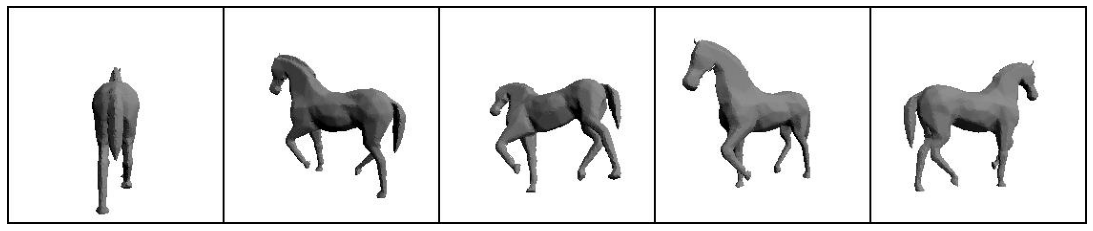

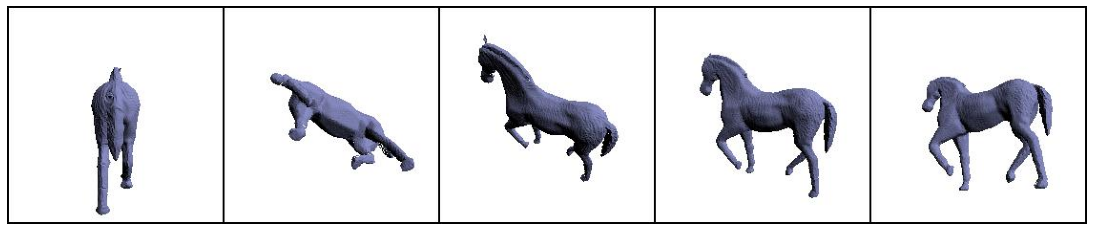

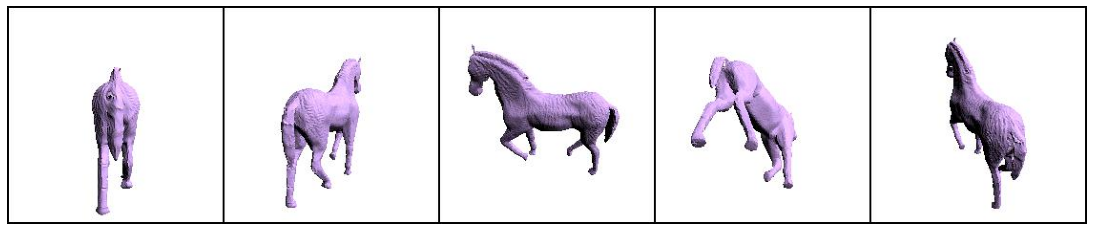

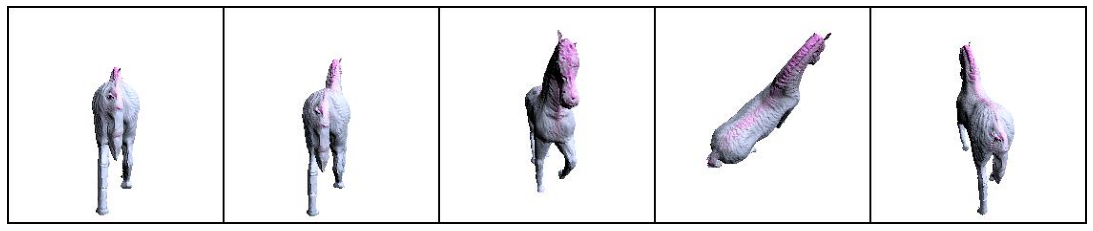

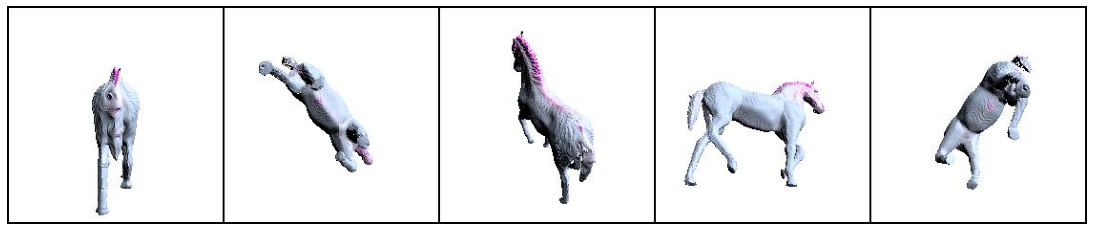

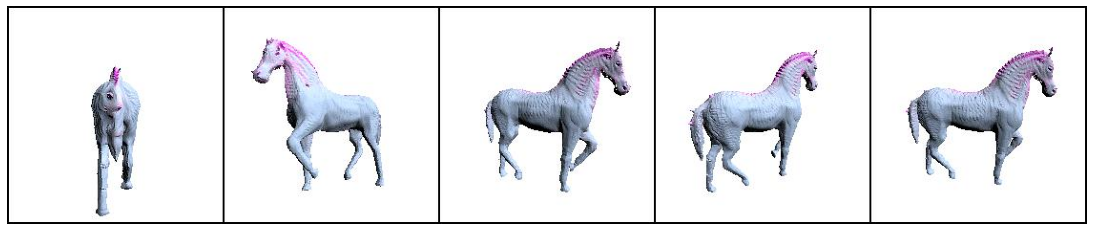

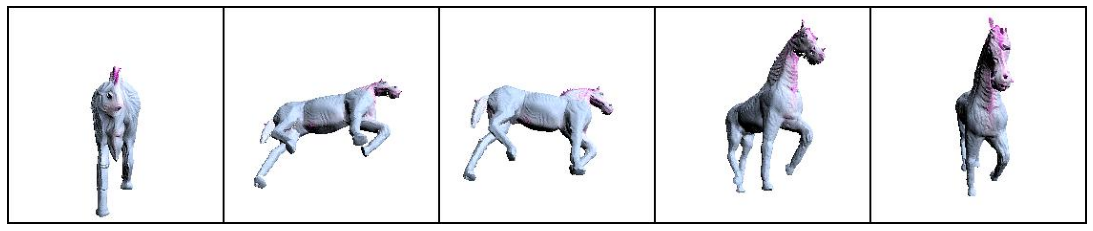

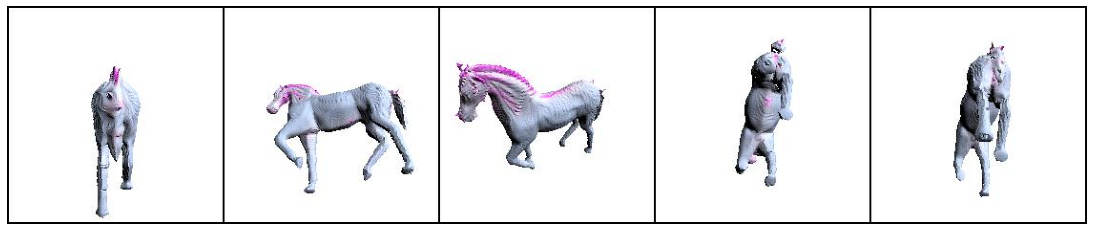

In [21]:
#@title export the results
import matplotlib.pyplot as plt
import importlib
import PIL
importlib.reload(PIL.TiffTags)
import cv2
import os


frames = []
for i in range(0, n_iter, 100):
    img = cv2.imread(os.path.join(output_dir, f"iter_{i}.jpg"))
    frames.append(img)
    plt.figure(figsize=(20, 4))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [22]:
#@title create video
from IPython.display import display, HTML
from base64 import b64encode
from tqdm.auto import tqdm
import cv2
fps = 2


video = cv2.VideoWriter("video.avi", 0, fps, frames[0].shape[:2][::-1]);
for im in tqdm(frames):
    video.write(im)
video.release()
!ffmpeg -y -i video.avi -pix_fmt yuv420p video.mp4 2> /dev/null
mp4 = open("video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""
<video width={frames[0].shape[1]} controls>
      <source src="{data_url}" type="video/mp4">
</video>
"""))

  0%|          | 0/8 [00:00<?, ?it/s]